# Código Python - Trabalho 2

## *Imports* estáticos

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [71]:
dados = pd.read_csv('dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'])
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [72]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Outcome                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Value                         49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [73]:
dados.describe()

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


In [74]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']


In [75]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Value']

#### Análise Univariável

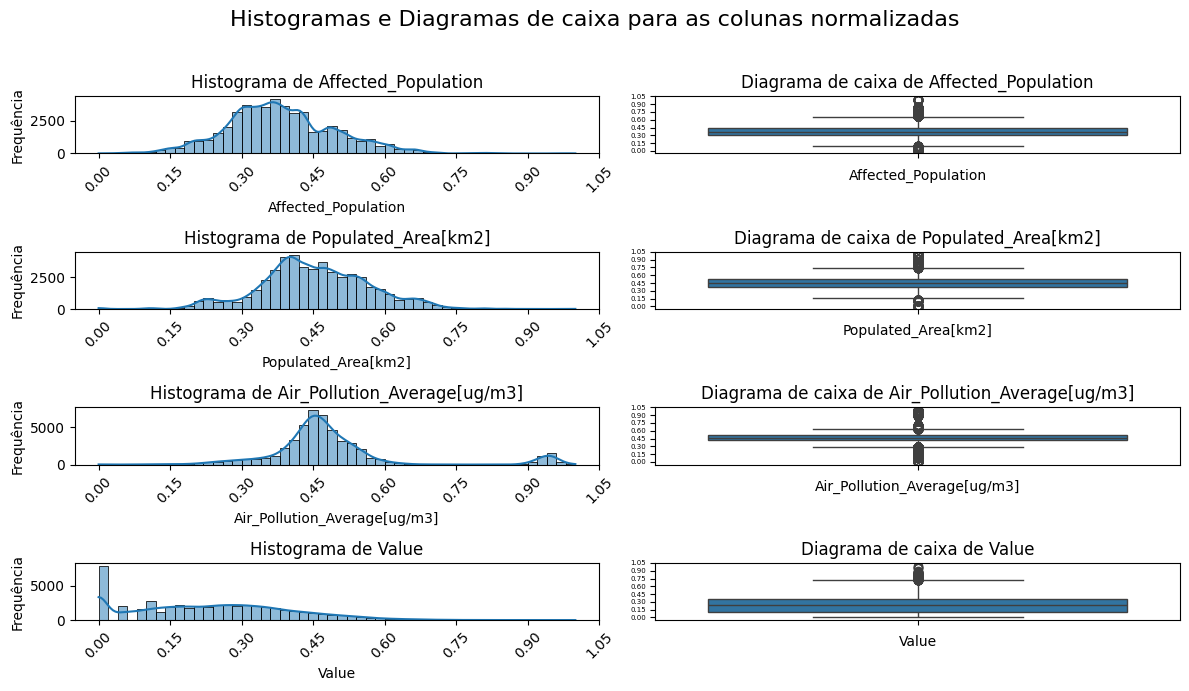

In [76]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

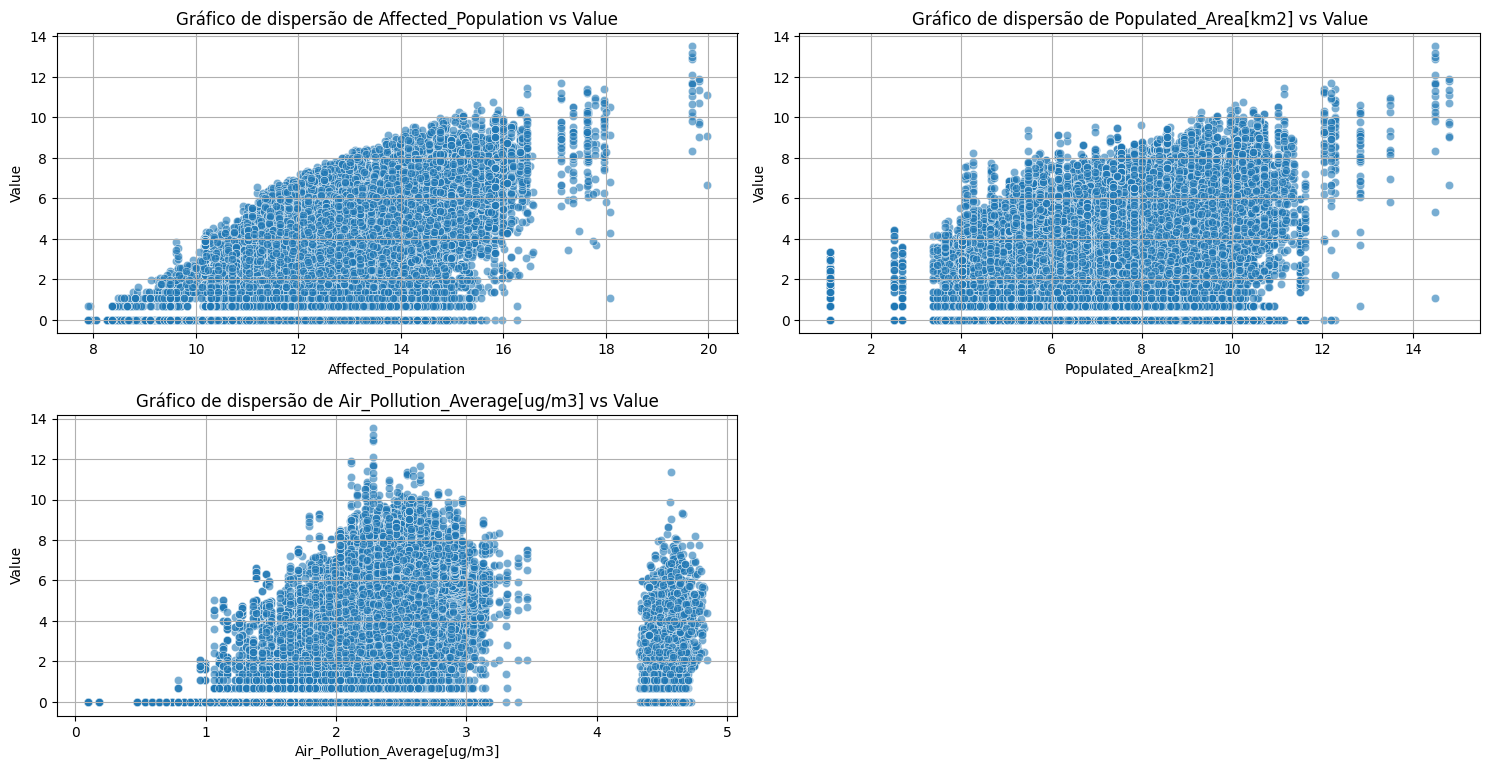

In [77]:
goalAttrib = 'Value'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

In [ ]:
# Que mais?

### 4.1.3. Pré-processamento dos dados

In [78]:
# O que faço aqui?

### 4.1.4. Agrupamento dos dados em zonas

In [82]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]